In [1]:
print("Hello worldo!")

Hello worldo!


In [2]:
# TODO:
# device = "cuda" if torch.cuda.is_available() else "cpu"
# model and batch: .to(device)

In [3]:
from __future__ import annotations
import typing

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(3654)

In [4]:
def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

### Get text data

In [5]:
with open("text_corpus.txt", encoding="utf-8") as f:
    text = f.read()[:10_000]

In [6]:
vocab = sorted(set(text))
print(vocab)

['\n', ' ', '%', "'", ',', '.', '0', '1', '2', '3', '5', '6', '7', '8', '9', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'W', 'Y', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [7]:
vocab_size = len(vocab)
vocab_size

62

### Encode the characters to integers

In [8]:
# Create encoder and decoder dicts

char_int_mapping = dict()
int_char_mapping = dict()

for i, c in enumerate(sorted(set(text))):
    char_int_mapping[c] = i
    int_char_mapping[i] = c

In [9]:
# examples
print(char_int_mapping["g"])
print(int_char_mapping[42])

42
g


In [10]:
def encode(string: str) -> List[int]:
    int_list = [char_int_mapping[char] for char in string]
    return int_list

def decode(int_list: List[int]) -> str:
    string = [int_char_mapping[num] for num in int_list]
    return "".join(string)

In [11]:
# examples
print(encode("hellooo"))
print(decode([43, 40, 47, 47, 50, 50, 50]))

[43, 40, 47, 47, 50, 50, 50]
hellooo


In [12]:
encode("hello world")

[43, 40, 47, 47, 50, 1, 58, 50, 53, 47, 39]

### Make it a tensor

In [13]:
data = torch.tensor(encode(text), dtype=torch.long)
data.shape

torch.Size([10000])

### Train/Test split

In [14]:
len(data)

10000

In [15]:
N = int(0.9*len(data))
train_data = data[:N]
test_data = data[N:]

print(len(train_data), len(test_data))

9000 1000


### Create minibatches

In [16]:
block_size = 8 # block_size is the maximum context length (input textblock size)
batch_size = 4

In [17]:
train_data[:block_size]

tensor([ 1, 53, 40, 48, 40, 48, 37, 40])

In [18]:
def get_batch(split: torch.tensor):
    offsets = np.random.randint(0, len(split) - batch_size, size=batch_size)
    x = torch.stack([split[i:i+block_size] for i in offsets])
    y = torch.stack([split[i+1:i+block_size+1] for i in offsets])
    return x, y

In [19]:
xb, yb = get_batch(train_data)
xb

tensor([[39,  0,  1, 53, 40, 54, 51, 40],
        [43, 44, 51,  4,  1, 60, 50, 56],
        [57, 40,  5,  1, 24, 55,  3, 54],
        [54, 56, 44, 55,  1, 50, 41,  1]])

In [20]:
yb

tensor([[ 0,  1, 53, 40, 54, 51, 40, 38],
        [44, 51,  4,  1, 60, 50, 56,  1],
        [40,  5,  1, 24, 55,  3, 54,  1],
        [56, 44, 55,  1, 50, 41,  1, 43]])

In [22]:
decode(xb[3].tolist())

'suit of '

In [25]:
for b in range(batch_size):
    print(f"----- BATCH {b} -----")
    
    for t in range(block_size):
        context = xb[b][:t+1]
        target = yb[b][t]
        print(f"context: {decode(context.tolist())} -> target: {decode([int(target)])}")
    print()
        
    for t in range(block_size):
        context = xb[b][:t+1]
        target = yb[b][t]
        print(f"context: {context.tolist()} -> target: {int(target)}")
    print()

----- BATCH 0 -----
context: d -> target: 

context: d
 -> target:  
context: d
  -> target: r
context: d
 r -> target: e
context: d
 re -> target: s
context: d
 res -> target: p
context: d
 resp -> target: e
context: d
 respe -> target: c

context: [39] -> target: 0
context: [39, 0] -> target: 1
context: [39, 0, 1] -> target: 53
context: [39, 0, 1, 53] -> target: 40
context: [39, 0, 1, 53, 40] -> target: 54
context: [39, 0, 1, 53, 40, 54] -> target: 51
context: [39, 0, 1, 53, 40, 54, 51] -> target: 40
context: [39, 0, 1, 53, 40, 54, 51, 40] -> target: 38

----- BATCH 1 -----
context: h -> target: i
context: hi -> target: p
context: hip -> target: ,
context: hip, -> target:  
context: hip,  -> target: y
context: hip, y -> target: o
context: hip, yo -> target: u
context: hip, you -> target:  

context: [43] -> target: 44
context: [43, 44] -> target: 51
context: [43, 44, 51] -> target: 4
context: [43, 44, 51, 4] -> target: 1
context: [43, 44, 51, 4, 1] -> target: 60
context: [43, 44, 51,

### Create a simple model

In [26]:
class BigramLanguageModel(nn.Module):
    
    def __init__(self, vocab_size):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)
    
    def forward(self, context, targets):
        logits = self.token_embedding_table(context) # (Batch, Time, Channels) ==> [4, 8, 62]

        B, T, C = logits.shape
        logits = logits.view(B*T,C) # [32,64]
        targets = targets.view(B*T) # [32]
        loss = F.cross_entropy(logits, targets)
        
        return logits, loss

    def generate(self, context, max_new_tokens):
        
        # context: (Batch, Time) ==> [4, 8]
        # -> extend context in Time dimension for max_new_tokens
        
        for _ in range(max_new_tokens):
            
            # get prediction
            logits, loss = self(xb, yb)
            
            # get logits for the last character 
            # (because we only need the last char to predict with our bigram model)
            logits = logits.view(batch_size,-1,vocab_size) # (B,T,C)
            logits = logits[:, -1, :] # (B,C) for only the last character
            
            probs = F.softmax(logits, dim=-1) # (B,C)
            next_token = torch.multinomial(probs, num_samples=1) # (B,1)
            
            # append next token to the sequence
            context = torch.cat((context, next_token), dim=1) # (B,T+1)
        
        return context
    
    def generate_to_text(self, context, max_new_tokens):
        context = self.generate(context, max_new_tokens)
        return decode(context[0].tolist())

model = BigramLanguageModel(vocab_size)
model

BigramLanguageModel(
  (token_embedding_table): Embedding(62, 62)
)

In [27]:
count_trainable_parameters(model)

3844

### Train the simple model

In [28]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [54]:
batch_size = 32
train_losses = []

for step in range(10_000):
    
    # get a batch
    xb, yb = get_batch(train_data)
    
    # predict and get loss
    logits, loss = model(xb, yb)
    
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())

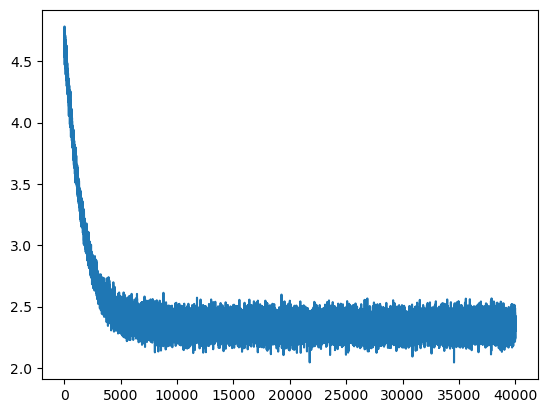

In [55]:
plt.plot(losses)

In [59]:
# inference
zero_context = torch.zeros((batch_size,1))
model.generate_to_text(zero_context, max_new_tokens=200)

"\nl    d fxry m  rsrs  yn r? rt nisr rte c rrra    srl  ,llaa  'r, osaoe .,aodti    unt d nnt a  ycrr x   saa   escr s  nsc   e uccrt r xr\n ?  s o cvcmlcarcrr  a nd y d d scynrtnsr n  orl\n die \nec rn lr"

### Attention

In [32]:
Q = torch.rand(5,1)
K = torch.rand(5,1)
V = torch.rand(5,1)
Q,K,V

(tensor([[0.5499],
         [0.5899],
         [0.8726],
         [0.8996],
         [0.7301]]),
 tensor([[0.4520],
         [0.8163],
         [0.5874],
         [0.7089],
         [0.1228]]),
 tensor([[0.8152],
         [0.7577],
         [0.0832],
         [0.2580],
         [0.2888]]))

In [128]:
def attention(Q,K,V):
    """ 
    Applies scaled dot-product attention
    between vectors of queries Q, keys K and values V. 
    """
    d_k = torch.tensor(Q.shape[0])
    W = (Q @ K.T) / torch.sqrt(d_k)
    
    # mask out forbidden connections
    tril = torch.tril(torch.ones((d_k, d_k)))
    W = W.masked_fill(tril==0, float("-inf"))
    
    W = F.softmax(W, dim=1)
    
    return W @ V

In [119]:
attention(Q,K,V)

tensor([[0.8152],
        [0.7851],
        [0.5539],
        [0.4780],
        [0.4451]])

### Multi-Head Attention

In [35]:
def multi_head_attention(Q,K,V):
    d_k = torch.tensor(Q.shape[0])
    d_model = 8 # project in to this space
    N_heads = 2
    
    # linear layers
    projections = {
        x: {
            h: nn.Linear(d_k, d_model, bias=False) for h in range(N_heads)
        } for x in ["Q", "K", "V"]
    }
    
    # layer to combine the concatenated attention-block output vectors
    top_layer = nn.Linear(N_heads * d_model, d_k, bias=False)
    
    # forward pass
    result = torch.zeros(N_heads, d_model, 1)

    for h in range(N_heads):
        result[h] = attention(
            projections["Q"][h](Q.T).T,
            projections["K"][h](K.T).T,
            projections["V"][h](V.T).T
        )
    
    concat_attn_out = result.view(1, N_heads * d_model)
    return top_layer(concat_attn_out).T

In [36]:
multi_head_attention(Q,K,V)

tensor([[ 0.0147],
        [ 0.0333],
        [-0.0315],
        [-0.0182],
        [-0.0582]], grad_fn=<PermuteBackward0>)

In [37]:
d_k = torch.tensor(Q.shape[0])
d_model = 8 # project in to this space
N_heads = 2

projections = {
    x: {
        h: nn.Linear(d_k, d_model, bias=False) for h in range(N_heads)
    } for x in ["Q", "K", "V"]
}

projections

{'Q': {0: Linear(in_features=5, out_features=8, bias=False),
  1: Linear(in_features=5, out_features=8, bias=False)},
 'K': {0: Linear(in_features=5, out_features=8, bias=False),
  1: Linear(in_features=5, out_features=8, bias=False)},
 'V': {0: Linear(in_features=5, out_features=8, bias=False),
  1: Linear(in_features=5, out_features=8, bias=False)}}

In [38]:
projections["Q"][0](Q.T).T

tensor([[-0.1686],
        [-0.4816],
        [ 0.1033],
        [-0.3457],
        [-0.7313],
        [-0.2949],
        [ 0.2788],
        [ 0.2492]], grad_fn=<PermuteBackward0>)

In [39]:
attention(Q,K,V)

tensor([[0.4440],
        [0.4442],
        [0.4460],
        [0.4461],
        [0.4451]])

In [40]:
result = torch.zeros(N_heads, d_model, 1)

for h in range(N_heads):
    result[h] = attention(
        projections["Q"][h](Q.T).T,
        projections["K"][h](K.T).T,
        projections["V"][h](V.T).T
    )

In [41]:
result

tensor([[[0.0284],
         [0.0300],
         [0.0270],
         [0.0293],
         [0.0313],
         [0.0291],
         [0.0261],
         [0.0262]],

        [[0.1080],
         [0.1065],
         [0.1060],
         [0.1106],
         [0.1073],
         [0.1085],
         [0.1066],
         [0.1064]]], grad_fn=<CopySlices>)

In [42]:
concat_attn_out = result.view(1, N_heads * d_model)
concat_attn_out

tensor([[0.0284, 0.0300, 0.0270, 0.0293, 0.0313, 0.0291, 0.0261, 0.0262, 0.1080,
         0.1065, 0.1060, 0.1106, 0.1073, 0.1085, 0.1066, 0.1064]],
       grad_fn=<ViewBackward0>)

In [43]:
top_layer = nn.Linear(N_heads * d_model, d_k, bias=False)

In [44]:
top_layer(concat_attn_out).T.shape

torch.Size([5, 1])

### Masking

In [113]:
T = 10
tril = torch.tril(torch.ones((T,T)))
tril

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

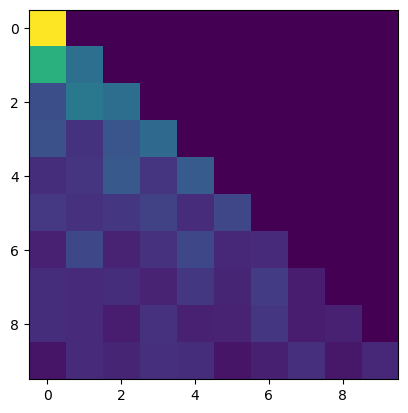

In [115]:
W = torch.rand((T,T)) # there will be real data here

# mask out forbidden connections
W = W.masked_fill(tril==0, float("-inf")) # set everywhere where tril is 0 to -inf (upper right)

W = F.softmax(W, dim=-1)
plt.imshow(W)

### Positional Encoding

### Transformer

In [ ]:
class BigramLanguageModel(nn.Module):
    
    def __init__(self, vocab_size):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)
    
    def forward(self, context, targets):
        logits = self.token_embedding_table(context) # (Batch, Time, Channels) ==> [4, 8, 62]

        B, T, C = logits.shape
        logits = logits.view(B*T,C) # [32,64]
        targets = targets.view(B*T) # [32]
        loss = F.cross_entropy(logits, targets)
        
        return logits, loss

    def generate(self, context, max_new_tokens):
        
        # context: (Batch, Time) ==> [4, 8]
        # -> extend context in Time dimension for max_new_tokens
        
        for _ in range(max_new_tokens):
            
            # get prediction
            logits, loss = self(xb, yb)
            
            # get logits for the last character 
            # (because we only need the last char to predict with our bigram model)
            logits = logits.view(batch_size,-1,vocab_size) # (B,T,C)
            logits = logits[:, -1, :] # (B,C) for only the last character
            
            probs = F.softmax(logits, dim=-1) # (B,C)
            next_token = torch.multinomial(probs, num_samples=1) # (B,1)
            
            # append next token to the sequence
            context = torch.cat((context, next_token), dim=1) # (B,T+1)
        
        return context
    
    def generate_to_text(self, context, max_new_tokens):
        context = self.generate(context, max_new_tokens)
        return decode(context[0].tolist())

model = BigramLanguageModel(vocab_size)
model